<a href="https://colab.research.google.com/github/GabrielFurnielesGarcia/deeplearning-2024/blob/main/IAGenerativa/LAB03_2_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>LAB3 IA Generativa - Imágenes</h1>
<h2>Ejercicio 2: GAN generadora de imágenes de zapatos</h2>


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

import tensorflow as tf
from tensorflow import keras
import keras.layers as layers

# Dataset

## Descarga

In [2]:
!wget http://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images-square.zip
!unzip ut-zap50k-images-square.zip

Streaming output truncated to the last 5000 lines.
  inflating: ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/PUMA/8058592.265680.jpg  
  inflating: ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/PUMA/8058593.137771.jpg  
  inflating: ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/PUMA/8058593.382709.jpg  
  inflating: ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/PUMA/8058594.382712.jpg  
  inflating: ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/PUMA/8058594.382713.jpg  
  inflating: ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/PUMA/8058594.84280.jpg  
  inflating: ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/PUMA/8058597.104236.jpg  
  inflating: ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/PUMA/8058597.186729.jpg  
  inflating: ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/PUMA/8058601.173596.jpg  
  inflating: ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/PUMA/8

## Visualizar algunas imágenes

Se tiene un total de 50066 imágenes


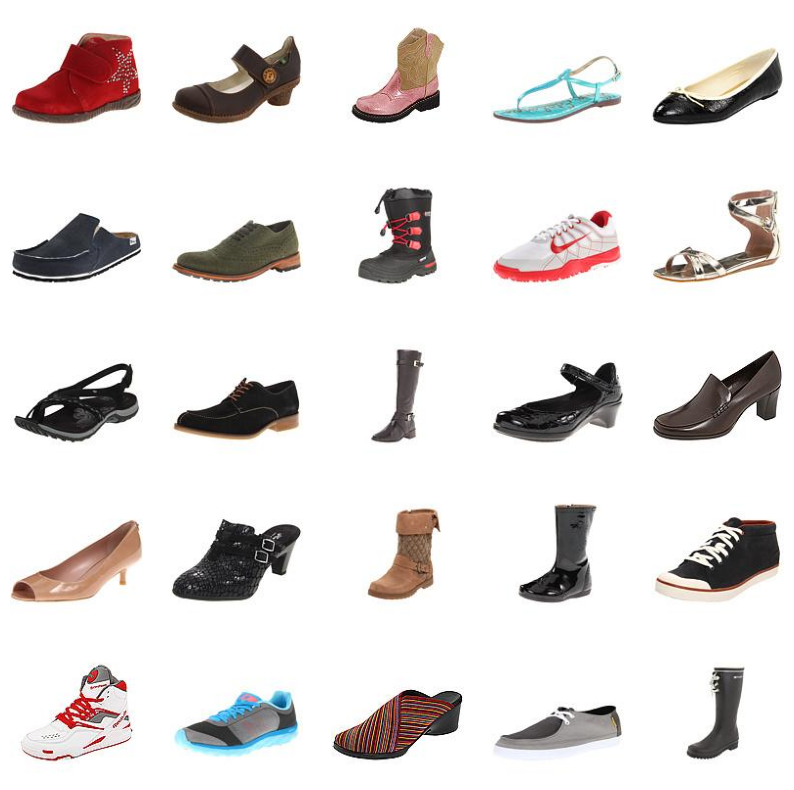

In [3]:
image_pattern = 'ut-zap50k-images-square/**/**.jpg'

img_paths = glob.glob(image_pattern, recursive=True)
print(f'Se tiene un total de {len(img_paths)} imágenes')

np.random.seed(42)
random_idx = np.random.randint(low=0,high=len(img_paths), size=25)

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
axes = axes.flatten()
for i, idx in enumerate(random_idx):
    img_path = img_paths[idx]
    img = plt.imread(img_path)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.show()

Cada imagen tiene dimensiones


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
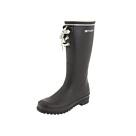

In [4]:
print('Cada imagen tiene dimensiones')
img

## tf.dataset

Se crea un pipeline de tensorflow con el objeto `tf.dataset`:

1) Cargar imagen

2) Redimensionar (64,64)

3) Normlizar valor de los píxeles al rango [0,1]

In [6]:
# Get the number of images for each split
num_images = len(img_paths)
train_size = int(num_images * 0.7)
val_size = int(num_images * 0.2)
test_size = num_images - train_size - val_size

# Create a dataset from the list of dictionaries
dataset = tf.data.Dataset.from_tensor_slices(img_paths)

# Shuffle the dataset
dataset = dataset.shuffle(buffer_size=num_images, seed=42)

# Split the dataset into train, val, and test sets
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size).take(test_size)

# Shuffle train_data
trains_dataset = train_dataset.shuffle(buffer_size=train_size, seed=42, reshuffle_each_iteration=True)

# Define a function to parse the image and label from the image path
def parse_image(img_path):
    # try:
    image = tf.io.read_file(img_path)
    image = tf.io.decode_image(image, expand_animations = False, channels=3) # expand_animations impide que se carguen GIFs
    image = tf.image.resize(image, [64, 64])  # Resize the image to the desired size
    image = (image - 127.5) / 127.5  # Normalize the image to [1,-1]
    return image

# Apply the parse_image function to each dataset
train_dataset = train_dataset.map(parse_image)
val_dataset = val_dataset.map(parse_image)
test_dataset = test_dataset.map(parse_image)

# Batch and prefetch the datasets for performance
batch_size = 32
train_dataset = train_dataset.batch(batch_size).prefetch(3)
val_dataset = val_dataset.batch(batch_size).prefetch(3)
test_dataset = test_dataset.batch(batch_size).prefetch(3)

Batch input shape: (32, 64, 64, 3)

Batch first image:


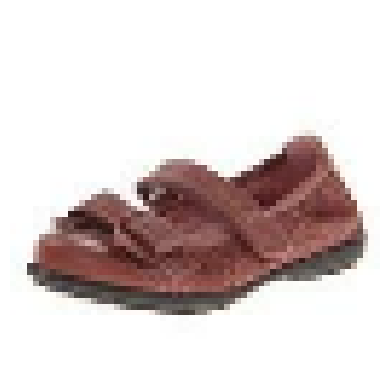

In [7]:
first_batch = train_dataset.take(1)
x = next(iter(first_batch))

print(f'Batch input shape: {x.shape}')

print('\nBatch first image:')
plt.imshow((x[0].numpy() * 127.5 + 127.5).astype(int))
plt.axis('off')
plt.show()


# Modelo GAN

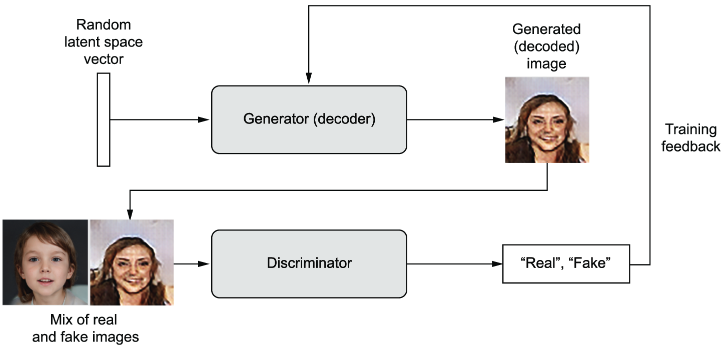

La arquitectura GAN (Generative Adversarial Network) se compone de dos módulos que, por sí solos, podrían considerarse modelos: El módulo Generador y el módulo Discriminador.

- **Generador (G)**: Módulo encargado de generar las imágenes (una vez le modelo GAN ha sido entrenado es el único módulo activo) El Generador toma una muestra del espacio latente (normalmente modelado por una distribución Gaussiana Normal) y, aplicando una serie de capas convolucionales, genera las imágenes.

- **Discriminador (D)**: Clasificador binario $\{0,1\}$ cuya tarea es predecir si la imagen que se le presenta pertenece a la distirbución de imágenes reales $p_\text{data}(x)$, en cuyo caso toma la etiqueta $1$, o si por el contrario es falsa (generada por el generador $p_z(z)$) tomando la etiqueta $0$.

El objetivo del modelo GAN es ser capaz de entrenar a un Generedaro lo suficientemente bueno para engañar al Discriminador. La función objetivo del modelo es una combinación de la función de pérdida del Discriminador y del Generador en lo que se conoce como el "juego min max" (_min max game_)

$$\underset{G}\min\underset{D}\max V(G,D) = \mathbb{E}_{x \sim p_\text{data}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_z(z)}[(1 - \log D(G(z)))]$$

El objetivo del módulo Generador (G) es minimizar está función, mientras el Discriminador (D) busca maximizarla.

En el bucle de entrenamiento primero el discriminador es entrenado durante varias iteraciones sobre muestras de mabsa dsitribuciones: real ($p_\text{data}(x)$) y generada (p_z(z)) y después es el generador el que es ajustado tomando única muestras de imágenes generadas:

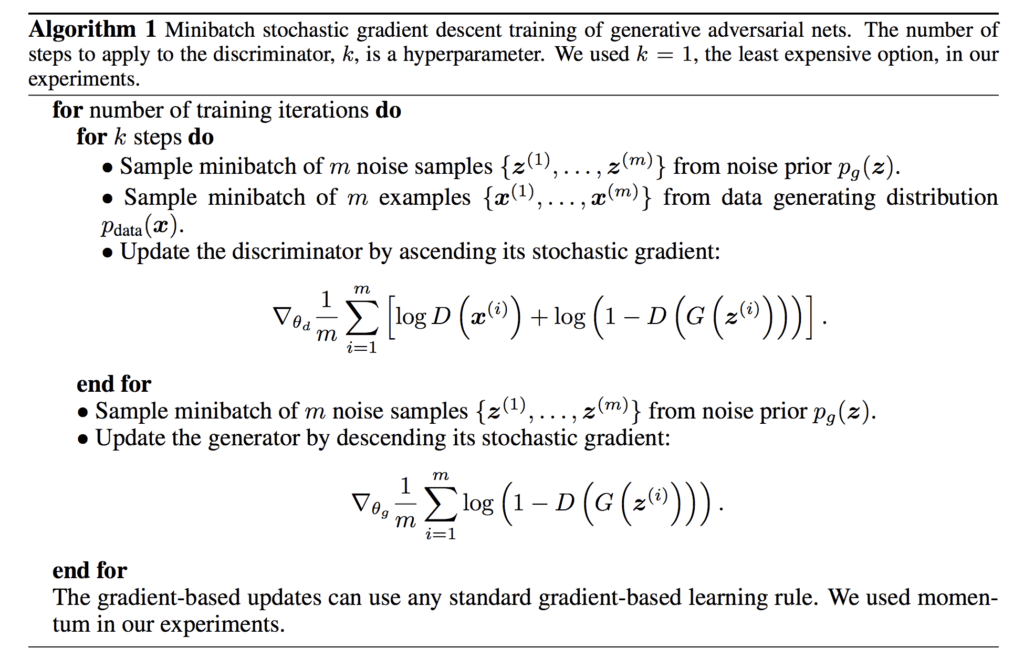


## Generador

In [8]:
# El espacio latente estará formado por vectores de 128 dimensiones.
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # Producimos la misma cantidad de coeficientes que teníamos
        # al nivel de la capa Flatten en el codificador.
        layers.Dense(8 * 8 * 128),
        # Revertimos la capa Flatten del codificador
        layers.Reshape((8, 8, 128)),
        # Revertimos las capas Conv2D del codificador.
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        # Usamos LeakyReLU como nuestra activación
        layers.LeakyReLU(alpha=0.2),
        # Revertimos las capas Conv2D del codificador.
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        # Usamos LeakyReLU como nuestra activación
        layers.LeakyReLU(alpha=0.2),
        # Revertimos las capas Conv2D del codificador.
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        # Usamos LeakyReLU como nuestra activación
        layers.LeakyReLU(alpha=0.2),
        # La salida termina con la forma (28, 28, 1)
        layers.Conv2D(3, kernel_size=5, padding="same", activation="tanh"),
    ],
    name="generator",
)

In [9]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       262272    
 anspose)                                                        
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 256)       524544    
 Transpose)                                                      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 256)       0 

## Discriminador

In [10]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        # Una capa de Dropout: ¡un truco importante!
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

In [11]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

## GAN

In [12]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        # Configura métricas para rastrear las dos
        # pérdidas en cada época de entrenamiento
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")
        self.d_val_loss_metric = keras.metrics.Mean(name="d_val_loss")
        self.g_val_loss_metric = keras.metrics.Mean(name="g_val_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Muestrea puntos aleatorios en el espacio latente
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))
        # Los decodifica a imágenes falsas
        generated_images = self.generator(random_latent_vectors)
        # Los combina con imágenes reales
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Ensambla etiquetas, discriminando imágenes reales de falsas
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],
            axis=0
        )
        # Agrega ruido aleatorio a las etiquetas: ¡un truco importante!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Entrenamos al discriminador
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(
            # Muestrea puntos aleatorios en el espacio latente
            shape=(batch_size, self.latent_dim))

        # Ensambla etiquetas de imágenes reales
        misleading_labels = tf.zeros((batch_size, 1))

        # Entrena al generador
        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result()}

    def test_step(self, real_images):
        # Muestrea puntos aleatorios en el espacio latente
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))
        # Los decodifica a imágenes falsas
        generated_images = self.generator(random_latent_vectors)
        # Los combina con imágenes reales
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Ensambla etiquetas, discriminando imágenes reales de falsas
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],
            axis=0
        )
        # Agrega ruido aleatorio a las etiquetas: ¡un truco importante!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Entrenamos al discriminador
        predictions = self.discriminator(combined_images)
        d_loss = self.loss_fn(labels, predictions)

        random_latent_vectors = tf.random.normal(
            # Muestrea puntos aleatorios en el espacio latente
            shape=(batch_size, self.latent_dim)
        )

        # Ensambla etiquetas de imágenes reales
        misleading_labels = tf.zeros((batch_size, 1))

        # Entrena al generador
        predictions = self.discriminator(
        self.generator(random_latent_vectors))
        g_loss = self.loss_fn(misleading_labels, predictions)

        self.d_val_loss_metric.update_state(d_loss)
        self.g_val_loss_metric.update_state(g_loss)
        return {"d_val_loss": self.d_val_loss_metric.result(),
                "g_val_loss": self.g_val_loss_metric.result()}

# Entrenamiento

In [13]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(f"generated_img_{epoch:03d}_{i}.png")

In [ ]:
from keras.callbacks import ModelCheckpoint

# latent_dim = 128
epochs = 30

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

# checkpoint callback
ckpt_save = ModelCheckpoint('checkpoints/gan_best_wieghts.h5', save_best_only=True, monitor='g_val_loss', mode='min')

gan.fit(
    train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=[ckpt_save, GANMonitor(num_img=3, latent_dim=latent_dim)]
)

Epoch 1/30
1096/1096 [==============================] - ETA: 0s - d_loss: 0.5760 - g_loss: 1.2244

1096/1096 [==============================] - 371s 335ms/step - d_loss: 0.5760 - g_loss: 1.2244 - val_d_val_loss: 0.6244 - val_g_val_loss: 0.8096
Epoch 2/30
1096/1096 [==============================] - ETA: 0s - d_loss: 0.6257 - g_loss: 1.0987

1096/1096 [==============================] - 328s 299ms/step - d_loss: 0.6257 - g_loss: 1.0987 - val_d_val_loss: 0.5851 - val_g_val_loss: 0.9151
Epoch 3/30
1096/1096 [==============================] - ETA: 0s - d_loss: 0.6338 - g_loss: 1.1068

1096/1096 [==============================] - 329s 300ms/step - d_loss: 0.6338 - g_loss: 1.1068 - val_d_val_loss: 0.6462 - val_g_val_loss: 0.9393
Epoch 4/30
1096/1096 [==============================] - ETA: 0s - d_loss: 0.6166 - g_loss: 1.1153

1096/1096 [==============================] - 329s 300ms/step - d_loss: 0.6166 - g_loss: 1.1153 - val_d_val_loss: 0.6243 - val_g_val_loss: 0.9584
Epoch 5/30
1096/1096 [==============================] - ETA: 0s - d_loss: 0.6012 - g_loss: 1.2037

1096/1096 [==============================] - 365s 333ms/step - d_loss: 0.6012 - g_loss: 1.2037 - val_d_val_loss: 0.6732 - val_g_val_loss: 0.9113
Epoch 6/30
1096/1096 [==============================] - ETA: 0s - d_loss: 0.5871 - g_loss: 1.2085

1096/1096 [==============================] - 325s 297ms/step - d_loss: 0.5871 - g_loss: 1.2085 - val_d_val_loss: 0.6088 - val_g_val_loss: 1.0581
Epoch 7/30
1096/1096 [==============================] - ETA: 0s - d_loss: 0.5505 - g_loss: 1.4546

1096/1096 [==============================] - 328s 299ms/step - d_loss: 0.5505 - g_loss: 1.4546 - val_d_val_loss: 0.5949 - val_g_val_loss: 1.0893
Epoch 8/30
1096/1096 [==============================] - ETA: 0s - d_loss: 0.5845 - g_loss: 1.2763

1096/1096 [==============================] - 329s 300ms/step - d_loss: 0.5845 - g_loss: 1.2763 - val_d_val_loss: 0.5805 - val_g_val_loss: 1.1087
Epoch 9/30
1096/1096 [==============================] - ETA: 0s - d_loss: 0.5914 - g_loss: 1.1630

1096/1096 [==============================] - 327s 299ms/step - d_loss: 0.5914 - g_loss: 1.1630 - val_d_val_loss: 0.5629 - val_g_val_loss: 1.1194
Epoch 10/30
1096/1096 [==============================] - ETA: 0s - d_loss: 0.6052 - g_loss: 1.1265

1096/1096 [==============================] - 365s 333ms/step - d_loss: 0.6052 - g_loss: 1.1265 - val_d_val_loss: 0.5539 - val_g_val_loss: 1.1784
Epoch 11/30
1096/1096 [==============================] - ETA: 0s - d_loss: 0.6075 - g_loss: 1.0956

1096/1096 [==============================] - 328s 299ms/step - d_loss: 0.6075 - g_loss: 1.0956 - val_d_val_loss: 0.5518 - val_g_val_loss: 1.1738
Epoch 12/30
1096/1096 [==============================] - ETA: 0s - d_loss: 0.6102 - g_loss: 1.1745

1096/1096 [==============================] - 365s 333ms/step - d_loss: 0.6102 - g_loss: 1.1745 - val_d_val_loss: 0.5430 - val_g_val_loss: 1.1754
Epoch 13/30
1096/1096 [==============================] - ETA: 0s - d_loss: 0.5988 - g_loss: 1.1232

1096/1096 [==============================] - 365s 333ms/step - d_loss: 0.5988 - g_loss: 1.1232 - val_d_val_loss: 0.5482 - val_g_val_loss: 1.1627
Epoch 14/30
1096/1096 [==============================] - ETA: 0s - d_loss: 0.5639 - g_loss: 1.3052

1096/1096 [==============================] - 328s 299ms/step - d_loss: 0.5639 - g_loss: 1.3052 - val_d_val_loss: 0.5434 - val_g_val_loss: 1.1648
Epoch 15/30
1096/1096 [==============================] - ETA: 0s - d_loss: 0.5843 - g_loss: 1.1846

1096/1096 [==============================] - 365s 333ms/step - d_loss: 0.5843 - g_loss: 1.1846 - val_d_val_loss: 0.5510 - val_g_val_loss: 1.1491
Epoch 16/30
1096/1096 [==============================] - ETA: 0s - d_loss: 0.6017 - g_loss: 1.0963

1096/1096 [==============================] - 365s 333ms/step - d_loss: 0.6017 - g_loss: 1.0963 - val_d_val_loss: 0.5385 - val_g_val_loss: 1.1754
Epoch 17/30
1096/1096 [==============================] - ETA: 0s - d_loss: 0.6005 - g_loss: 1.1199

1096/1096 [==============================] - 329s 300ms/step - d_loss: 0.6005 - g_loss: 1.1199 - val_d_val_loss: 0.5487 - val_g_val_loss: 1.1593
Epoch 18/30
1096/1096 [==============================] - ETA: 0s - d_loss: 0.5952 - g_loss: 1.1479

1096/1096 [==============================] - 329s 300ms/step - d_loss: 0.5952 - g_loss: 1.1479 - val_d_val_loss: 0.5457 - val_g_val_loss: 1.1546
Epoch 19/30
1096/1096 [==============================] - ETA: 0s - d_loss: 0.5907 - g_loss: 1.1644

1096/1096 [==============================] - 365s 333ms/step - d_loss: 0.5907 - g_loss: 1.1644 - val_d_val_loss: 0.5508 - val_g_val_loss: 1.1479
Epoch 20/30
1096/1096 [==============================] - ETA: 0s - d_loss: 0.5850 - g_loss: 1.1613

1096/1096 [==============================] - 328s 299ms/step - d_loss: 0.5850 - g_loss: 1.1613 - val_d_val_loss: 0.5510 - val_g_val_loss: 1.1448
Epoch 21/30
1096/1096 [==============================] - ETA: 0s - d_loss: 0.5798 - g_loss: 1.1565

1096/1096 [==============================] - 328s 299ms/step - d_loss: 0.5798 - g_loss: 1.1565 - val_d_val_loss: 0.5536 - val_g_val_loss: 1.1471
Epoch 22/30
1096/1096 [==============================] - ETA: 0s - d_loss: 0.5730 - g_loss: 1.1954

1096/1096 [==============================] - 365s 333ms/step - d_loss: 0.5730 - g_loss: 1.1954 - val_d_val_loss: 0.5577 - val_g_val_loss: 1.1353
Epoch 23/30
1096/1096 [==============================] - ETA: 0s - d_loss: 0.5774 - g_loss: 1.1750

1096/1096 [==============================] - 365s 333ms/step - d_loss: 0.5774 - g_loss: 1.1750 - val_d_val_loss: 0.5594 - val_g_val_loss: 1.1396
Epoch 24/30
1096/1096 [==============================] - ETA: 0s - d_loss: 0.5651 - g_loss: 1.2236

1096/1096 [==============================] - 329s 300ms/step - d_loss: 0.5651 - g_loss: 1.2236 - val_d_val_loss: 0.5547 - val_g_val_loss: 1.1377
Epoch 25/30
 212/1096 [====>.........................] - ETA: 3:52 - d_loss: 0.5727 - g_loss: 1.2286

Debido a que el coste computacional de entrenar el modelo GAN es muy alto ,y por consiguiente requiere de largos tiempos de ejecución (casi 6 minutos/ época), Google Colab detuvo el entrenamiento en la época 25. Pese a tener definida una función _callback_ para guardar una copia de los pesos con el mejor modelo, por razones desconocidas tensorflow la ha obviado.

No obstante, si atendemos a la convergencia de la función de pérdida en los conjuntos de entrenamiento y de validación, vemos como el Generador tiende a minimizar el error al mismo tiempo que el Discriminador oscila*, lo que supone una buena señal de que el modelo está aprendiendo.

(*) Cabe mencionar que el entrenamiento de redes GAN es inestable y la convergencia de las funciones objetivo no es _suave_ sino que se producen saltos.

# Resultados

Debido a los problemas con Google Colab no se dispone de un modelo entrenado que testear. En su lugar, se ha utilizado un modelo público de Hugging Face* que ha sido entrenado en un dataset similar (no se especifica en la tarjeta del modelo)

[Link al modelo](https://huggingface.co/Apocalypse-19/shoe-generator)

(*) El modelo utilizado es un modelo Difusor, una arquitectura diferente a las GAN

In [ ]:
!pip install diffusers
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 5.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

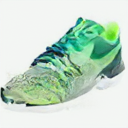

In [ ]:
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('Apocalypse-19/shoe-generator')
image = pipeline()
image.images[0]

Pese a estar ya entrenado el modelo, la inferencia de una sola imagen en una CPU ha requerido cerca de 15 minutos!

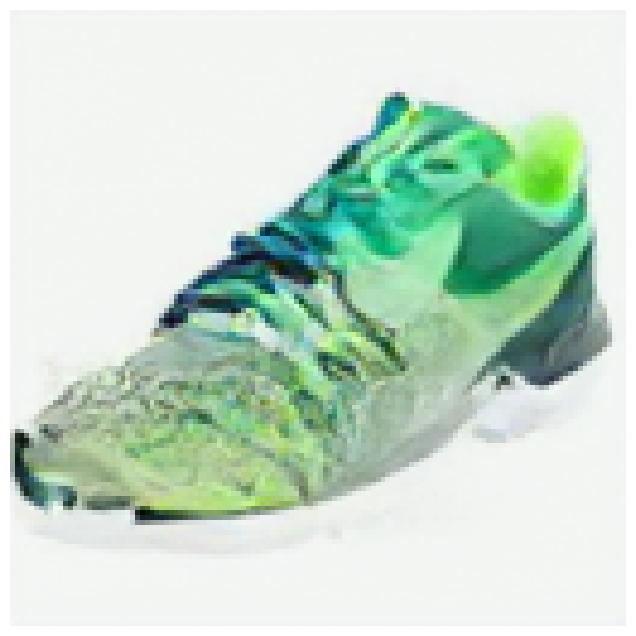

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.imshow(image.images[0])
plt.axis('off')
plt.show()

# Conclusiones

Las Redes Generativas Adversarias (GAN) representan una arquitectura de red neuronal sumamente poderosa, introduciendo un nuevo enfoque en el proceso de entrenamiento de modelos de Aprendizaje Profundo mediante la competencia entre dos redes (_entrenamiento adversarial_).

Dado que este método implica el entrenamiento simultáneo de dos modelos, el proceso resulta muy costoso en recursos computacionales y tiempo. Por consiguiente, se recomienda encarecidamente emplear unidades de procesamiento gráfico (GPU) tanto para la fase de inferencia como para la de entrenamiento.